Follow this guide to select the correct conda environment\
https://stackoverflow.com/questions/66869413/visual-studio-code-does-not-detect-virtual-environments

In [1]:
import os
os.environ['NUMEXPR_MAX_THREADS'] = '128'

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
#print(sys.executable)
from importlib import reload

import collections
import os
import subprocess
import numpy as np

import confidence.confidence_tools as confidence_tools

from IPython import display
from collections import defaultdict
import py3Dmol
import pandas as pd
#pd.set_option('display.max_columns', None)

# import drawing library
import matplotlib.pyplot as plt
import seaborn as sns


In [21]:
# CHANGE
id="8av2"
model=(4,2)
prediction=(29,2)
preset="default"


# # CHANGE
# id="7x8t"
# model=(1,4)
# prediction=(2,29)
# preset="default"

In [22]:
# Software
MMalign_exe="/home/sfromm/programs/MMalign/MMalign"

# Directories
tmp = "/home/sfromm/tmp"
native_pdb = f"/home/sfromm/git/abag-benchmark-set/data/db/structures_filtered/{id}_filtered.pdb"
path_scores = f"/home/sfromm/git/abag-benchmark-set/data/scores_ae/{preset}/output/{id}/scores.csv"

#f"/home/sfromm/git/abag-benchmark-set/data/scores_ae/{preset}/output/{id}/{id}_model_{model}_multimer_v3_pred_{prediction}_{preset}/{id}_model_{model}_multimer_v3_pred_{prediction}_{preset}_merged.csv"


# Parameters
pdb1_cut = f"/home/sfromm/git/abag-benchmark-set/data/scores_ae/{preset}/output/{id}/{id}_model_{model[0]}_multimer_v3_pred_{prediction[0]}_{preset}/{id}_model_{model[0]}_multimer_v3_pred_{prediction[0]}_{preset}_cut_query.pdb"
pdb2_cut = f"/home/sfromm/git/abag-benchmark-set/data/scores_ae/{preset}/output/{id}/{id}_model_{model[1]}_multimer_v3_pred_{prediction[1]}_{preset}/{id}_model_{model[1]}_multimer_v3_pred_{prediction[1]}_{preset}_cut_query.pdb"
pdb1 = f"/mnt/sdb/users/sfromm/benchmarking-data/models/{preset}/{id}complex/unrelaxed_model_{model[0]}_multimer_v3_pred_{prediction[0]}_{preset}.pdb"
pdb2 = f"/mnt/sdb/users/sfromm/benchmarking-data/models/{preset}/{id}complex/unrelaxed_model_{model[1]}_multimer_v3_pred_{prediction[1]}_{preset}.pdb"
pkl1 = f"/mnt/sdb/users/sfromm/benchmarking-data/models/{preset}/{id}complex/result_model_{model[0]}_multimer_v3_pred_{prediction[0]}_{preset}.pkl"
pkl2 = f"/mnt/sdb/users/sfromm/benchmarking-data/models/{preset}/{id}complex/result_model_{model[1]}_multimer_v3_pred_{prediction[1]}_{preset}.pkl"
features = f"/mnt/sdb/users/sfromm/benchmarking-data/models/{preset}/{id}complex/features.pkl"


# Model selection

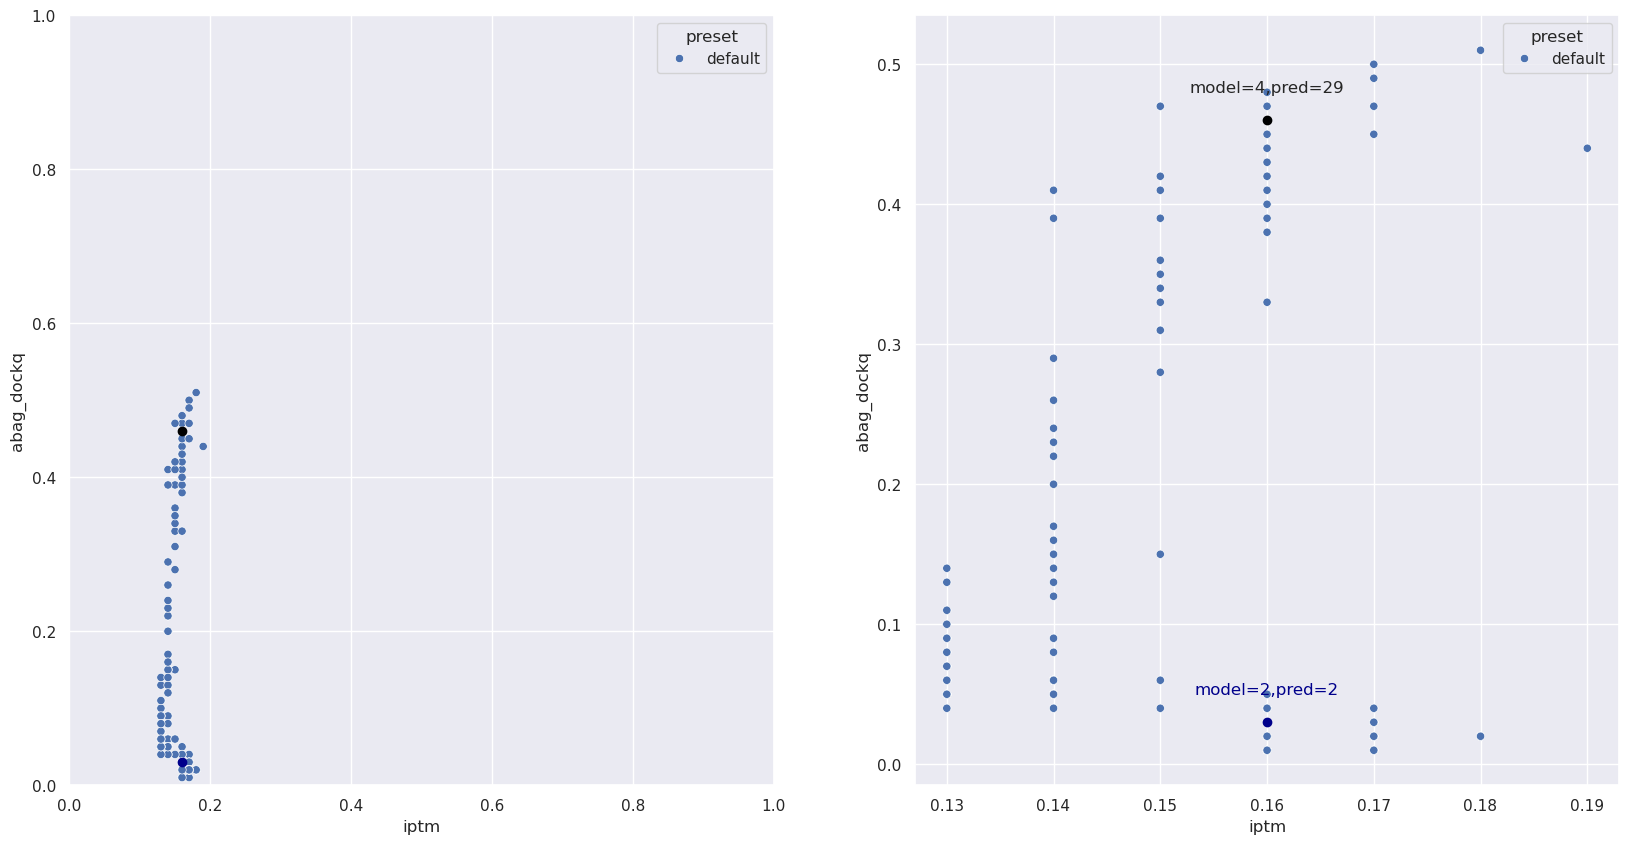

Selected model 1: 429
Selected model 2: 22


In [5]:
df_scores = pd.read_csv(path_scores, sep=',')

# Set style
sns.set_theme()

n_x_axis=2
fig, axes = plt.subplots(1, n_x_axis, figsize=(n_x_axis*10, 1*10))


x1=df_scores[(df_scores['model']==f"model_{model[0]}_multimer_v3") & (df_scores['prediction']==prediction[0]) ].iloc[0]['iptm']
y1=df_scores[(df_scores['model']==f"model_{model[0]}_multimer_v3") & (df_scores['prediction']==prediction[0]) ].iloc[0]['abag_dockq']
x2=df_scores[(df_scores['model']==f"model_{model[1]}_multimer_v3") & (df_scores['prediction']==prediction[1]) ].iloc[0]['iptm']
y2=df_scores[(df_scores['model']==f"model_{model[1]}_multimer_v3") & (df_scores['prediction']==prediction[1]) ].iloc[0]['abag_dockq']


# First axes
ax=axes[0]
ax.set_xlim((0,1))
ax.set_ylim((0,1))
sns.scatterplot(ax=ax, data=df_scores,x='iptm',y='abag_dockq', hue='preset', style='preset')
ax.scatter(x1, y1, color = 'black')
ax.scatter(x2, y2, color = 'darkblue')

# Second axes
ax = axes[1]
sns.scatterplot(ax=ax, data=df_scores,x='iptm',y='abag_dockq', hue='preset', style='preset')
ax.scatter(x1, y1, color = 'black')
ax.scatter(x2, y2, color = 'darkblue')
ax.text(x1, y1+0.02, f"model={model[0]},pred={prediction[0]}", ha='center')
ax.text(x2, y2+0.02, f"model={model[1]},pred={prediction[1]}", ha='center', color='darkblue')

plt.show()
plt.close()
print('\n'.join([f"Selected model {i+1}: {model[i]}{prediction[i]}" for i in [0,1]]))


# Predicted TM terms

In [6]:
# Load the CSV data
df = df_scores

# Initialize custom_score column
df["mean_pae"] = None
df["mean_pae_interface"] = None
df["l1_norm_pae"] = None
df["l2_norm_pae"] = None
df["l1_norm_pae_interface"] = None
df["l2_norm_pae_interface"] = None

# Iterate through rows to calculate custom_score
features_path = f"/mnt/sdb/users/sfromm/benchmarking-data/models/{preset}/{id}complex/features.pkl"
asym_id = confidence_tools.load_data_from_pkl(features_path)["asym_id"]

for index, row in df.iterrows():
    # Extract required fields
    preset = row["preset"]
    id_ = row["sample_id"].split("_")[0]  # Extracting ID (before first underscore)
    model = row["model"]
    prediction = row["prediction"]
    
    # Construct pickle file path
    pkl_path = f"/mnt/sdb/users/sfromm/benchmarking-data/models/{preset}/{id}complex/result_{model}_pred_{prediction}_{preset}.pkl"
    pkl_data = confidence_tools.load_data_from_pkl(pkl_path)

    try:
        pae = pkl_data['predicted_aligned_error']
        if pae is not None:
            df.at[index, "mean_pae"] = pae.mean()  # Compute mean PAE
            df.at[index, "l1_norm_pae"] = np.linalg.norm(pae, ord=1)  # Compute L1 norm
            df.at[index, "l2_norm_pae"] = np.linalg.norm(pae, ord=2)  # Compute L2 norm
        else:
            print("No PAE data")
        del pae  # Delete pae explicitly
    except Exception as e:
        print(f"Error loading PAE from {pkl_path}: {e}")

    interface_mask = asym_id[:, None] != asym_id[None, :]

    try:
        pae_interface = pkl_data['predicted_aligned_error'] * interface_mask
        if pae_interface is not None:
            df.at[index, "mean_pae_interface"] = pae_interface.mean()  # Compute mean PAE interface
            df.at[index, "l1_norm_pae_interface"] = np.linalg.norm(pae_interface, ord=1)  # Compute L1 norm
            df.at[index, "l2_norm_pae_interface"] = np.linalg.norm(pae_interface, ord=2)  # Compute L2 norm
        else:    
            print("No PAE interface data")
        del pae_interface  # Delete pae explicitly
    except Exception as e:
        print(f"Error loading PAE from {pkl_path}: {e}")




    

In [27]:
pkl1_data = confidence_tools.load_data_from_pkl(pkl1)
pkl2_data = confidence_tools.load_data_from_pkl(pkl2)

pdb1_structure = confidence_tools.load_pdb_structure(pdb1)
pdb2_structure = confidence_tools.load_pdb_structure(pdb2)

asym_id_1  = confidence_tools.compute_asym_id_from_pdb(pdb1_structure)
asym_id_2  = confidence_tools.compute_asym_id_from_pdb(pdb2_structure)

features_data = confidence_tools.load_data_from_pkl(features)
asym_id_1_from_data = features_data['asym_id']
asym_id_2_from_data = asym_id_1_from_data


num_res=asym_id_1.shape[0]

aligned_confidence_probs_1=pkl1_data['aligned_confidence_probs']
aligned_confidence_probs_2=pkl2_data['aligned_confidence_probs']

predicted_tm_terms_1 = confidence_tools.calculate_predicted_tm_score(
            aligned_confidence_probs_1, return_predicted_tm_term=True
        )
predicted_tm_terms_2 = confidence_tools.calculate_predicted_tm_score(
            aligned_confidence_probs_2, return_predicted_tm_term=True
        )

per_alignment_1 = confidence_tools.calculate_predicted_tm_score(
            aligned_confidence_probs_1, return_per_alignment=True
        )
per_alignment_2 = confidence_tools.calculate_predicted_tm_score(
            aligned_confidence_probs_2, return_per_alignment=True
        )

try:
    iptm1 = confidence_tools.calculate_predicted_tm_score(
                aligned_confidence_probs_1, asym_id=asym_id_1,interface=True
    )
    iptm2 = confidence_tools.calculate_predicted_tm_score(
                aligned_confidence_probs_2, asym_id=asym_id_2,interface=True
    )
except:
    print("WRONG SHAPE! FALLING BACK TO FEATURES ASYM ID")
    iptm1 = confidence_tools.calculate_predicted_tm_score(
                aligned_confidence_probs_1, asym_id=asym_id_1_from_data,interface=True
    )
    iptm2 = confidence_tools.calculate_predicted_tm_score(
                aligned_confidence_probs_2, asym_id=asym_id_2_from_data,interface=True
    )


pae1=pkl1_data['predicted_aligned_error']
pae2=pkl2_data['predicted_aligned_error']

plddt_1=pkl1_data['plddt']
plddt_2=pkl2_data['plddt']


WRONG SHAPE! FALLING BACK TO FEATURES ASYM ID


In [26]:
print(aligned_confidence_probs_1.shape)
print(asym_id_1.shape)
print(asym_id_1_from_data.shape)

(327, 327, 64)
(326,)
(327,)


In [29]:
print(asym_id_1)
print(asym_id_1_from_data)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
[1. 1. 

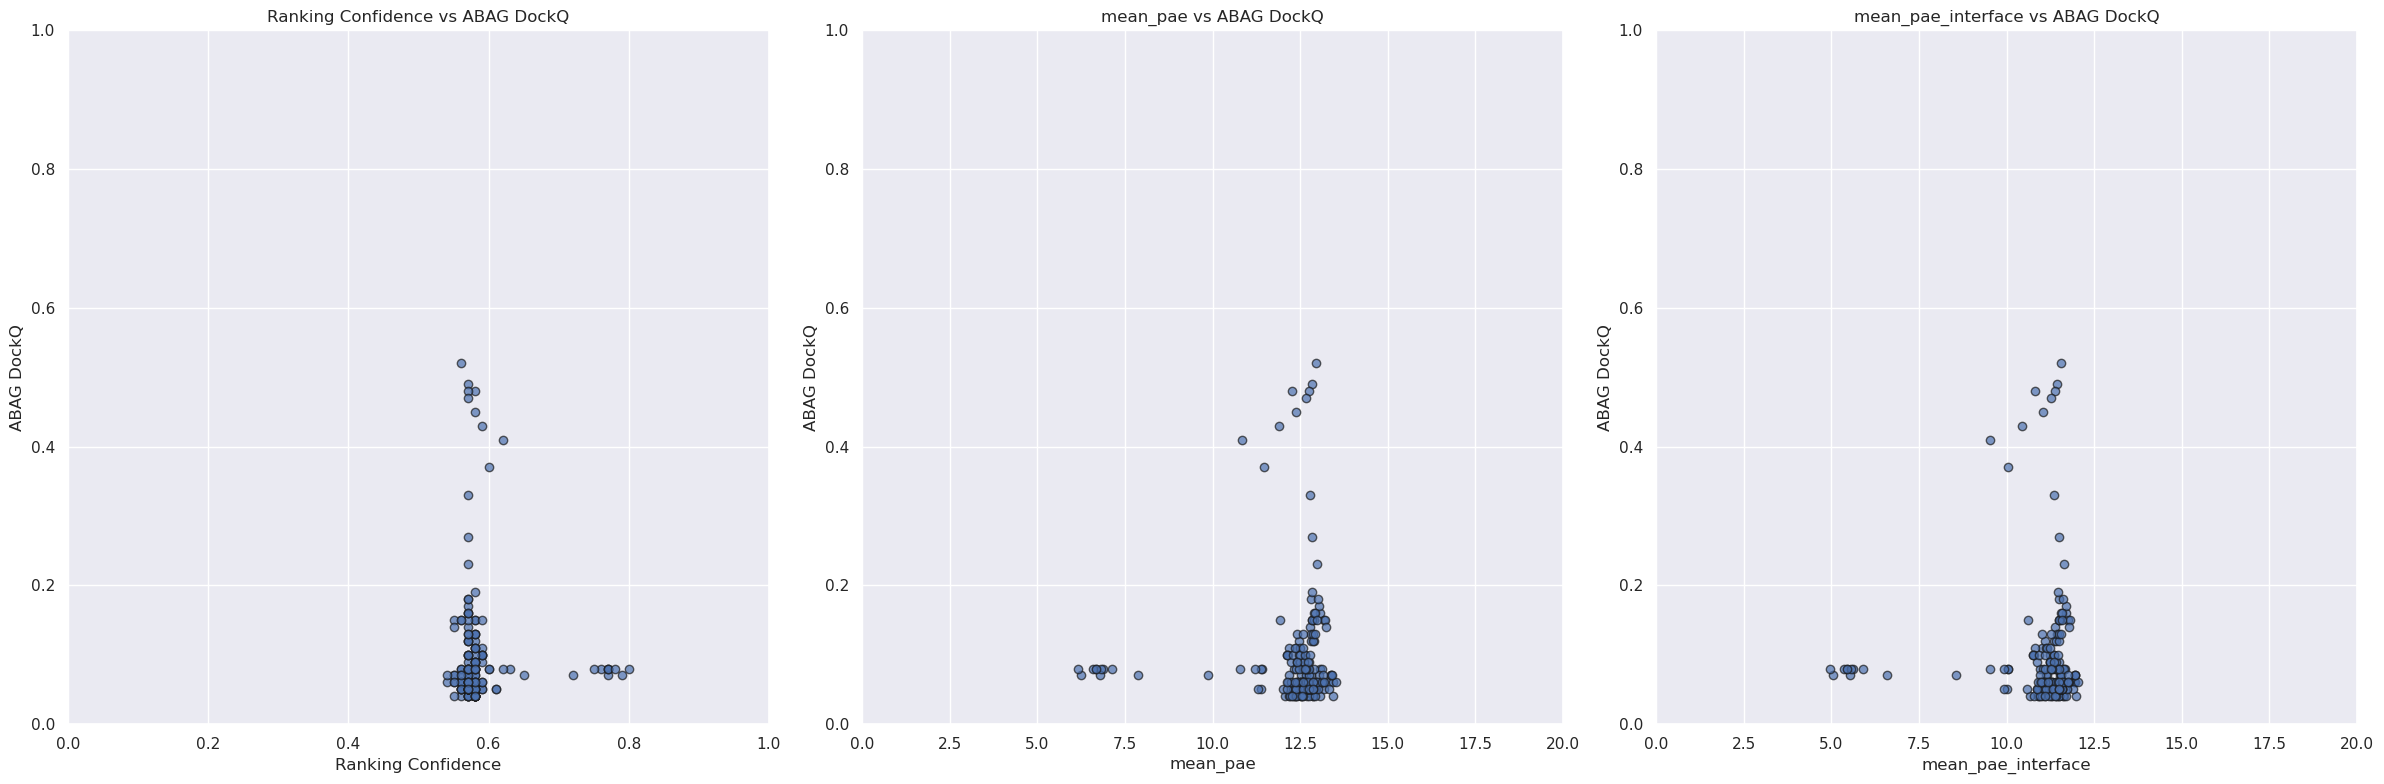

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Drop rows where ranking_confidence, custom_score, or abag_dockq is NaN
#df = df.dropna(subset=["ranking_confidence", "custom_score", "abag_dockq"])


# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Plot ranking_confidence vs abag_dockq
axes[0].scatter(df["ranking_confidence"], df["abag_dockq"], alpha=0.7, edgecolors='k')
axes[0].set_xlabel("Ranking Confidence")
axes[0].set_ylabel("ABAG DockQ")
axes[0].set_title("Ranking Confidence vs ABAG DockQ")
axes[0].set_xlim(0,1)
axes[0].set_ylim(0, 1)
axes[0].grid(True)

# Plot custom_score vs abag_dockq
axes[1].scatter(df["mean_pae"], df["abag_dockq"], alpha=0.7, edgecolors='k')
axes[1].set_xlabel("mean_pae")
axes[1].set_ylabel("ABAG DockQ")
axes[1].set_title("mean_pae vs ABAG DockQ")
axes[1].set_xlim(0,20)
axes[1].set_ylim(0, 1)
axes[1].grid(True)

# Plot custom_score vs abag_dockq
axes[2].scatter(df["mean_pae_interface"], df["abag_dockq"], alpha=0.7, edgecolors='k')
axes[2].set_xlabel("mean_pae_interface")
axes[2].set_ylabel("ABAG DockQ")
axes[2].set_title("mean_pae_interface vs ABAG DockQ")
axes[2].set_xlim(0,20)
axes[2].set_ylim(0, 1)
axes[2].grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


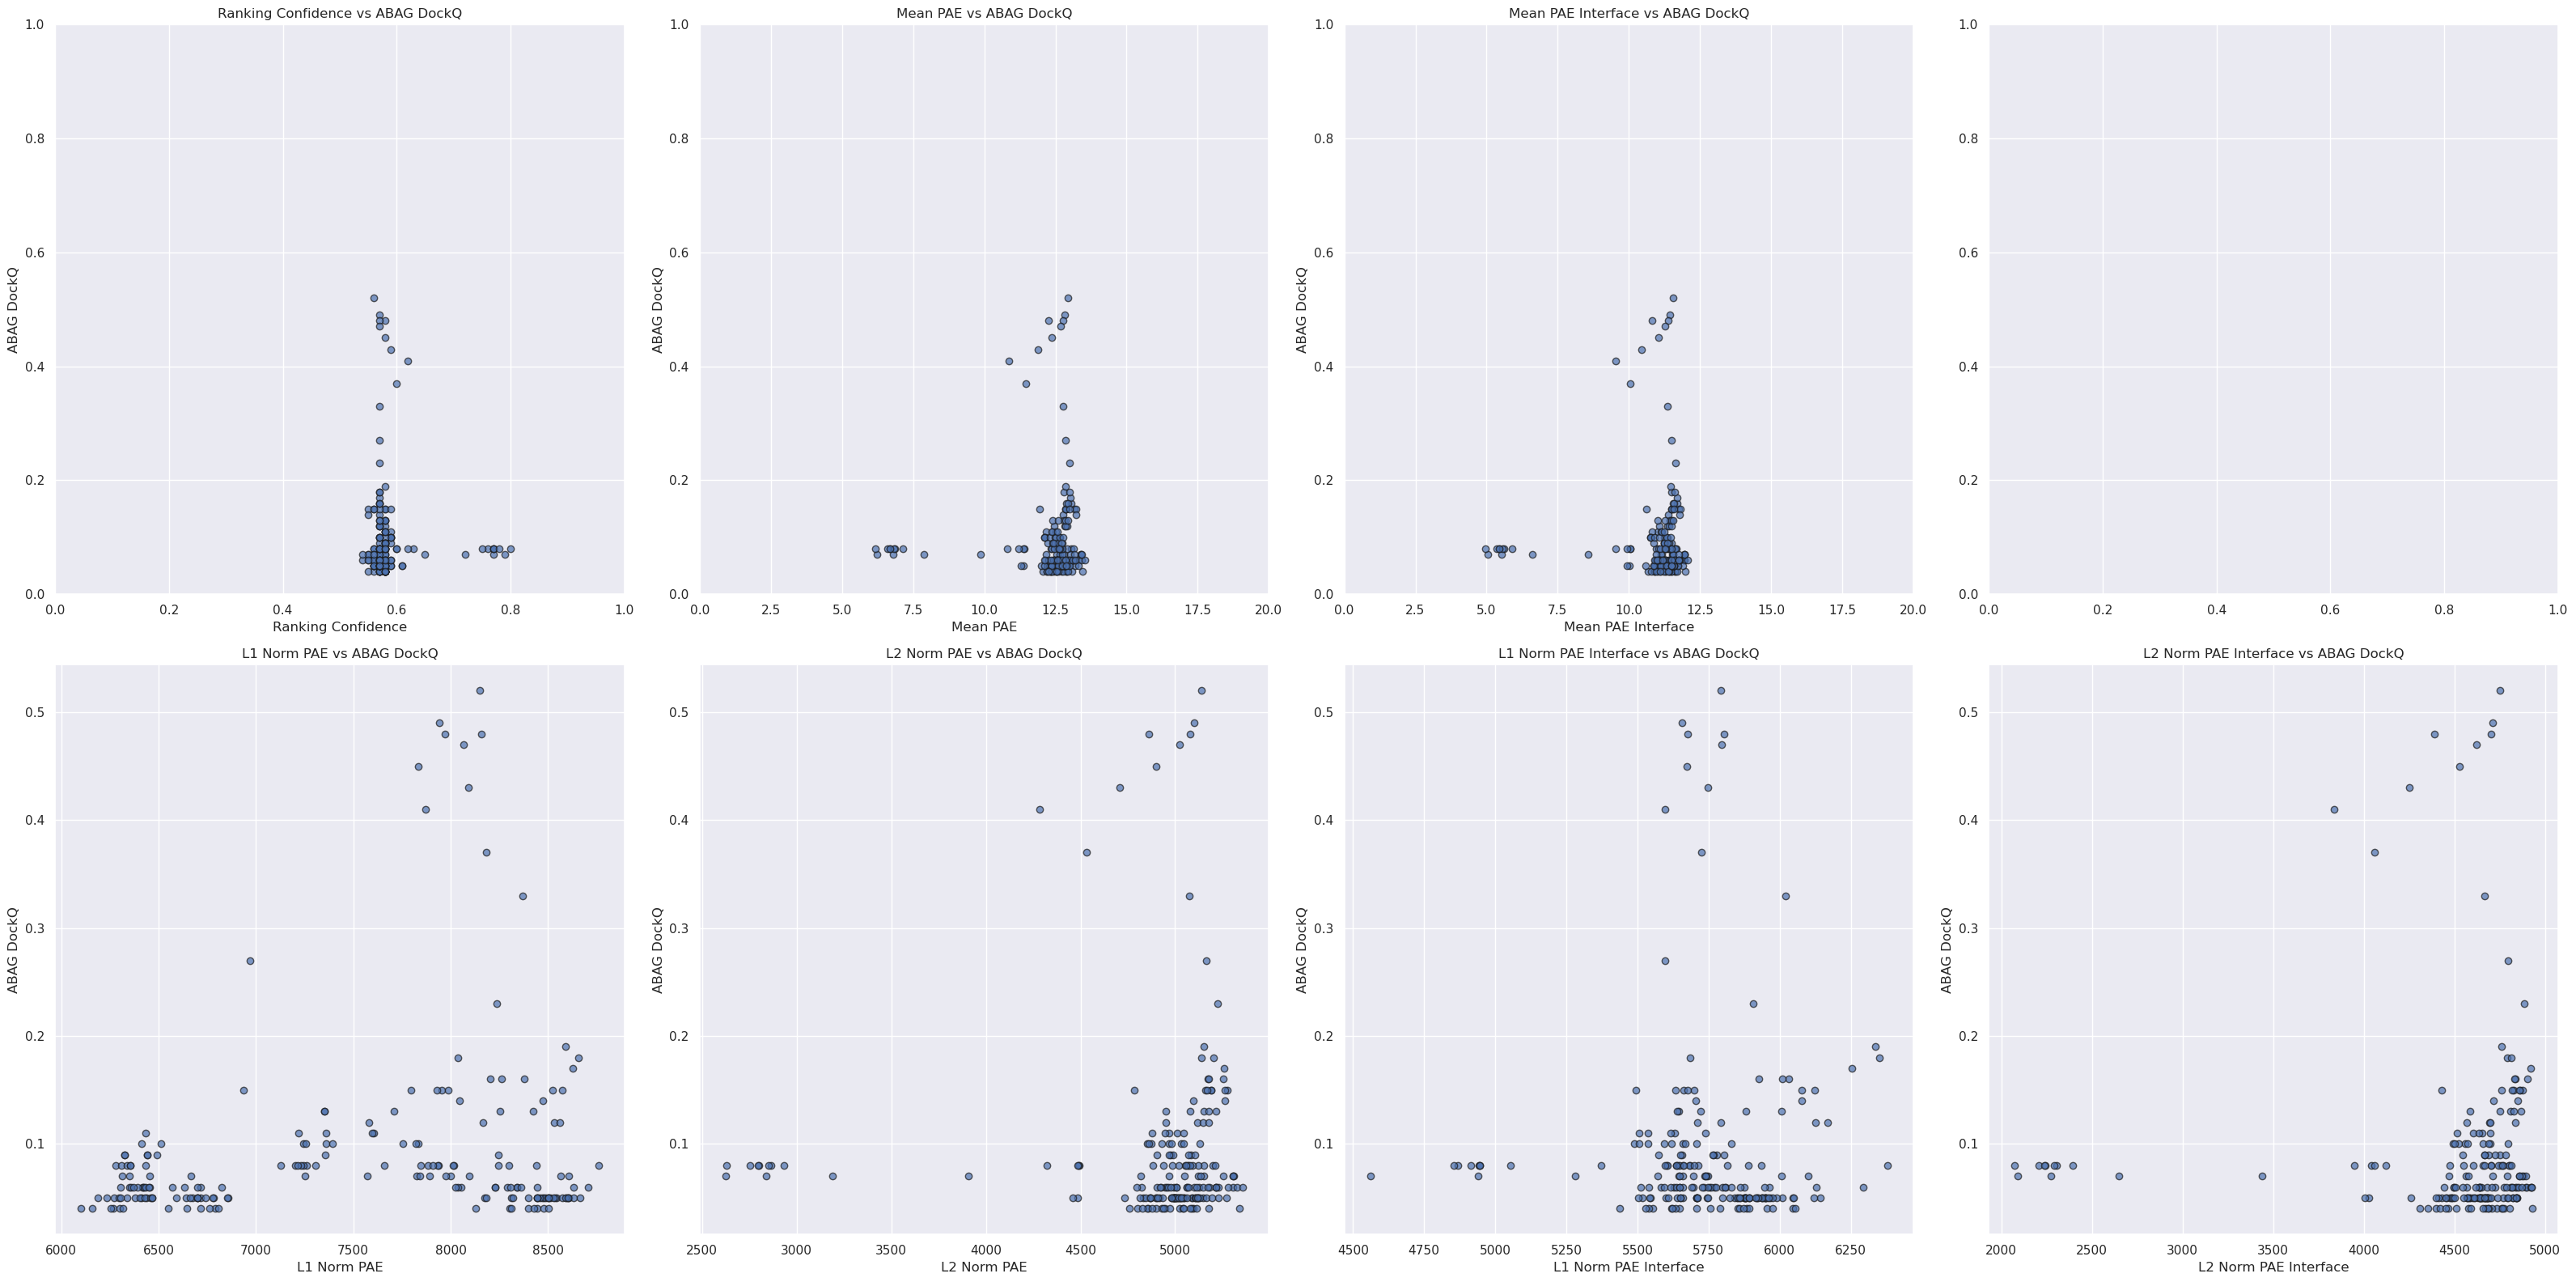

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Drop rows where ranking_confidence, custom_score, or abag_dockq is NaN
#df = df.dropna(subset=["ranking_confidence", "custom_score", "abag_dockq"])

# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 4, figsize=(32, 16))

# Plot ranking_confidence vs abag_dockq
axes[0, 0].scatter(df["ranking_confidence"], df["abag_dockq"], alpha=0.7, edgecolors='k')
axes[0, 0].set_xlabel("Ranking Confidence")
axes[0, 0].set_ylabel("ABAG DockQ")
axes[0, 0].set_title("Ranking Confidence vs ABAG DockQ")
axes[0, 0].set_xlim(0,1)
axes[0, 0].set_ylim(0, 1)
axes[0, 0].grid(True)

# Plot mean_pae vs abag_dockq
axes[0, 1].scatter(df["mean_pae"], df["abag_dockq"], alpha=0.7, edgecolors='k')
axes[0, 1].set_xlabel("Mean PAE")
axes[0, 1].set_ylabel("ABAG DockQ")
axes[0, 1].set_title("Mean PAE vs ABAG DockQ")
axes[0, 1].set_xlim(0,20)
axes[0, 1].set_ylim(0, 1)
axes[0, 1].grid(True)

# Plot mean_pae_interface vs abag_dockq
axes[0, 2].scatter(df["mean_pae_interface"], df["abag_dockq"], alpha=0.7, edgecolors='k')
axes[0, 2].set_xlabel("Mean PAE Interface")
axes[0, 2].set_ylabel("ABAG DockQ")
axes[0, 2].set_title("Mean PAE Interface vs ABAG DockQ")
axes[0, 2].set_xlim(0,20)
axes[0, 2].set_ylim(0, 1)
axes[0, 2].grid(True)

# Plot L1 norm PAE vs abag_dockq
axes[1, 0].scatter(df["l1_norm_pae"], df["abag_dockq"], alpha=0.7, edgecolors='k')
axes[1, 0].set_xlabel("L1 Norm PAE")
axes[1, 0].set_ylabel("ABAG DockQ")
axes[1, 0].set_title("L1 Norm PAE vs ABAG DockQ")
axes[1, 0].grid(True)

# Plot L2 norm PAE vs abag_dockq
axes[1, 1].scatter(df["l2_norm_pae"], df["abag_dockq"], alpha=0.7, edgecolors='k')
axes[1, 1].set_xlabel("L2 Norm PAE")
axes[1, 1].set_ylabel("ABAG DockQ")
axes[1, 1].set_title("L2 Norm PAE vs ABAG DockQ")
axes[1, 1].grid(True)

# Plot L1 norm PAE Interface vs abag_dockq
axes[1, 2].scatter(df["l1_norm_pae_interface"], df["abag_dockq"], alpha=0.7, edgecolors='k')
axes[1, 2].set_xlabel("L1 Norm PAE Interface")
axes[1, 2].set_ylabel("ABAG DockQ")
axes[1, 2].set_title("L1 Norm PAE Interface vs ABAG DockQ")
axes[1, 2].grid(True)

# Plot L2 norm PAE Interface vs abag_dockq
axes[1, 3].scatter(df["l2_norm_pae_interface"], df["abag_dockq"], alpha=0.7, edgecolors='k')
axes[1, 3].set_xlabel("L2 Norm PAE Interface")
axes[1, 3].set_ylabel("ABAG DockQ")
axes[1, 3].set_title("L2 Norm PAE Interface vs ABAG DockQ")
axes[1, 3].grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
print(pae1.mean())
print(pae2.mean())
print((pae1-pae2).mean())

11.8877125
12.725502
-0.8377897


In [ ]:
# my jupyter notebook keeps crashing, maybe because of too large a variable? no idea
try:
    del pkl1_data
except:
    pass
try:
    del pkl2_data
except:
    pass


In [ ]:
# Some functions for drawing
plt.style.use('default')
def plot_matrix(
    mat1, mat2, filepath=None, limits1=None, limits2=None, name1="mat1", name2="mat2", title=None, figsize=7,
):

    color_map = "seismic" #"viridis"

    plot_objects = [mat1, mat2]
    limits = [limits1,limits2]
    titles = [name1,name2]
    if mat1.shape == mat2.shape:
        plot_objects.append(mat1-mat2)
        titles.append(f"{name1} - {name2}")
        if limits1==limits2:
            limits.append(limits1)
        else:
            limits.append(None)

    n_x_axis = len(plot_objects)
    fig, axes = plt.subplots(1, n_x_axis, figsize=(n_x_axis * figsize, 1 * figsize))
    for i in range(n_x_axis):
        p = axes[i].imshow(plot_objects[i], cmap=color_map)
        plt.colorbar(p, ax=axes[i], fraction=0.046, pad=0.05)
        if limits[i] is not None:
            for limit in limits[i]:
                # horizontal line
                axes[i].plot([0,plot_objects[i].shape[0]-1], [limit,limit], color="red", linewidth=2) 
                # vertical line
                axes[i].plot([limit,limit], [0,plot_objects[i].shape[1]-1], color="red", linewidth=2) 
        axes[i].title.set_text(titles[i])

    if title is not None:
        fig.suptitle(title, fontsize=30)

    if filepath is not None:
        plt.savefig(filepath, dpi=600)
    else:
        plt.show()
    plt.close()
    return


def plot_vec(
    vec1, vec2,filepath=None,  limits=None, name1="vec1", name2="vec2",title=None,
):
    l = vec1.shape[0]
    assert l == vec2.shape[0]
    X = np.arange(l)

    # Figure Size

    n_x_axis = 2
    fig, axes = plt.subplots(1, n_x_axis, figsize=(n_x_axis * 7, 1 * 7))

    # vec1 and vec2
    i=0
    axes[i].bar(X + 0.00, vec1, color="blue", alpha=1, width=1)
    axes[i].bar(X + 0.00, vec2, color="green", alpha = 0.5, width=1)
    axes[i].legend(labels=[name1,name2])
    #axes[i].set_ylim((0,1))

    # difference
    i=1
    axes[i].bar(X + 0.00, vec1-vec2, color="blue", width=1)
    axes[i].legend(labels=[f"{name1}-{name2}"])


    for i in [0,1]:
        if limits is not None:
            for limit in limits:

                ax00 = axes[i].twinx()
                # Plot a line
                ax00.axvline(x=limit, color="r")

                ax00.annotate(
                    f"{limit}",
                    xy=(limit, 0),
                    xytext=(limit, -0.1),
                    arrowprops=dict(facecolor="black", shrink=0.05),
                )


    if filepath is not None:
        plt.savefig(filepath, dpi=600)
    else:
        plt.show()
    plt.close()
    return

def get_chain_limits(asym_id):
    chain_limits = []
    chain_ids = asym_id.astype("int")
    for i in range(chain_ids[-1]):
        #chain_starts = np.where(chain_ids == i + 1)[0][0] + 1
        chain_stops = np.where(chain_ids == i + 1)[0][-1] + 1
        chain_limits.append(chain_stops - 1)
    chain_limits.pop()
    if chain_limits == []:
        return None
    return chain_limits

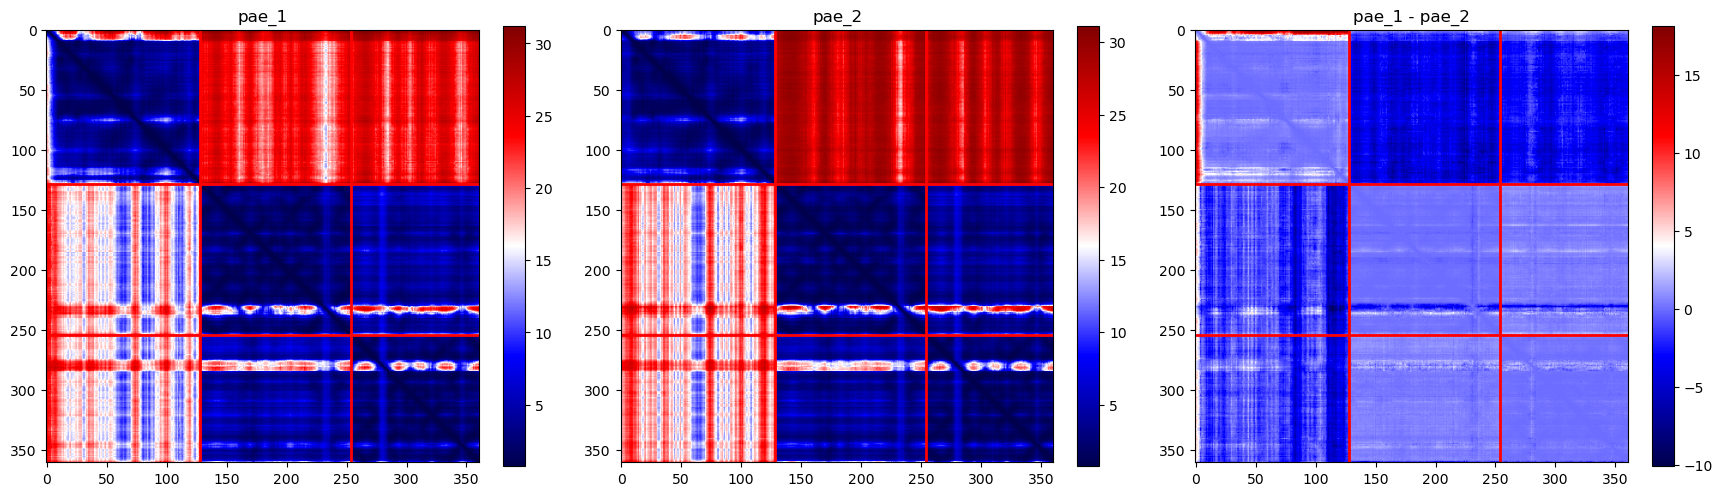

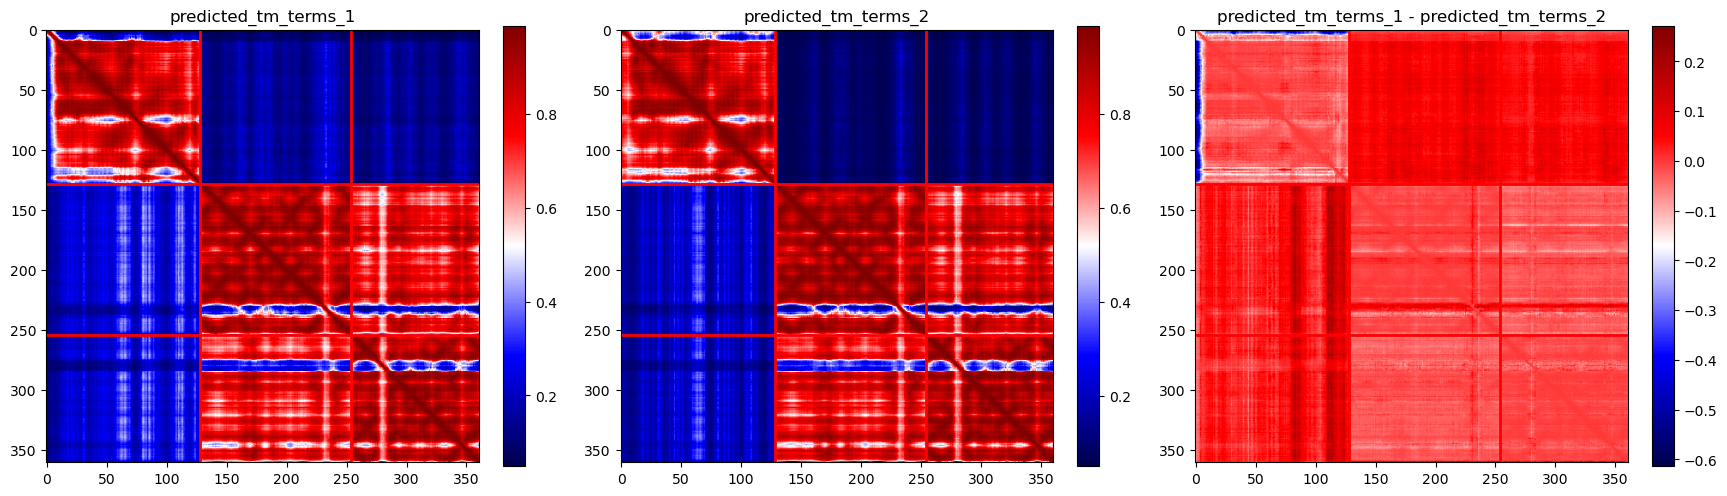

In [ ]:

plot_matrix(
    mat1=pae1,
    mat2=pae2,
    name1='pae_1',
    name2='pae_2',
    limits1=get_chain_limits(asym_id_1),
    limits2=get_chain_limits(asym_id_2),
    #title="Predicted Aligned Error"
)

plot_matrix(
    mat1=predicted_tm_terms_1,
    mat2=predicted_tm_terms_2,
    name1='predicted_tm_terms_1',
    name2='predicted_tm_terms_2',
    limits1=get_chain_limits(asym_id_1),
    limits2=get_chain_limits(asym_id_2),
    #title="Predicted TM Terms"
)

In [ ]:
def plot_matrix_multi(
    mat1_lst, mat2_lst, filepath=None, limits1=None, limits2=None, name1="mat1", name2="mat2", title=None, figsize=7,
):
    

    color_map = "viridis"
    assert len(mat1_lst) == len(mat2_lst)

    n_y_axis = len(mat1_lst)
    if n_y_axis < 2:
        return # TODO
    n_x_axis = 3
    fig, axes = plt.subplots(nrows=n_y_axis, ncols=n_x_axis, figsize=(n_x_axis * figsize, n_y_axis * figsize))

    for y_ax in range(n_y_axis):
        mat1 = mat1_lst[y_ax]
        mat2 = mat2_lst[y_ax]


        plot_objects = [mat1, mat2]
        limits = [limits1,limits2]
        titles = [name1,name2]
        assert mat1.shape == mat2.shape
        plot_objects.append(mat1-mat2)
        titles.append(f"{name1} - {name2}")
        if limits1==limits2:
            limits.append(limits1)
        else:
            limits.append(None)


        for i in range(n_x_axis):
            p = axes[y_ax,i].imshow(plot_objects[i], cmap=color_map)
            plt.colorbar(p, ax=axes[y_ax,i], fraction=0.046, pad=0.05)
            if limits[i] is not None:
                for limit in limits[i]:
                    # horizontal line
                    axes[y_ax,i].plot([0,plot_objects[i].shape[0]-1], [limit,limit], color="red", linewidth=2) 
                    # vertical line
                    axes[y_ax,i].plot([limit,limit], [0,plot_objects[i].shape[1]-1], color="red", linewidth=2) 
            axes[y_ax,i].title.set_text(titles[i])

    if title is not None:
        fig.suptitle(title, fontsize=30)

    if filepath is not None:
        plt.savefig(filepath, dpi=600)
    else:
        plt.show()
    plt.close()
    return


num_bins=64
bins = range(64)
bins = bins[:] # sections with too much output (plots) seem to crash the notebook
mat1_lst = [aligned_confidence_probs_1[:,:,bin] for bin in bins]
mat2_lst = [aligned_confidence_probs_2[:,:,bin] for bin in bins]

if False:
    plot_matrix_multi(
        mat1_lst=mat1_lst,
        mat2_lst=mat2_lst,
        name1=f'acprobs_1',
        name2=f'acprobs_2',
        limits1=get_chain_limits(asym_id_1),
        limits2=get_chain_limits(asym_id_2),
        #title="Predicted TM Terms"
        figsize=4.5,
    )


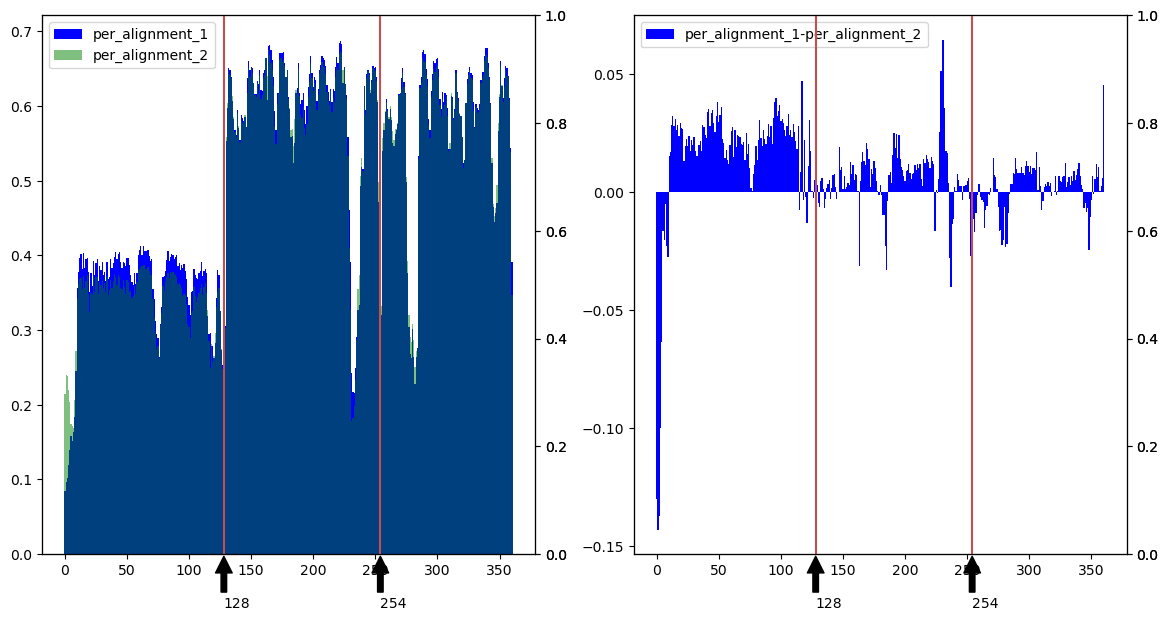

In [ ]:


plot_vec(
    vec1=per_alignment_1,
    vec2=per_alignment_2,
    limits=get_chain_limits(asym_id_1),
    name1="per_alignment_1",
    name2="per_alignment_2"
)


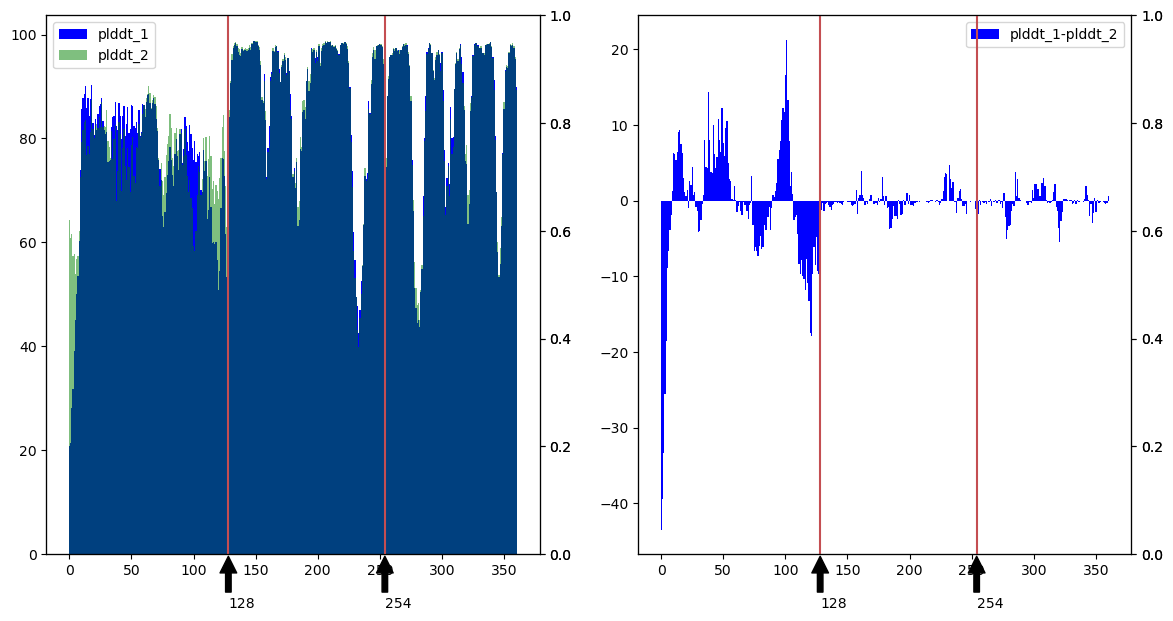

In [ ]:
plot_vec(
    vec1=plddt_1,
    vec2=plddt_2,
    limits=get_chain_limits(asym_id_1),
    name1="plddt_1",
    name2="plddt_2"
)

# Norms

In [ ]:
# Calculate norms


In [ ]:



aligned_confidence_probs_diff = np.absolute(aligned_confidence_probs_1 - aligned_confidence_probs_2)
ptm_diff_acb = confidence_tools.calculate_predicted_tm_score(
            aligned_confidence_probs_diff
        )
ptm1 = confidence_tools.calculate_predicted_tm_score(
            aligned_confidence_probs_1)
ptm2 = confidence_tools.calculate_predicted_tm_score(
            aligned_confidence_probs_2)
ptm_diff = ptm1 - ptm2
assert np.array_equal(asym_id_1,asym_id_2)
iptm_diff_acb = confidence_tools.calculate_predicted_tm_score(
            aligned_confidence_probs=aligned_confidence_probs_diff, asym_id=asym_id_1,interface=True,
        )
iptm_diff = confidence_tools.calculate_predicted_tm_score(
            aligned_confidence_probs=aligned_confidence_probs_1,asym_id=asym_id_1,interface=True,
        ) - confidence_tools.calculate_predicted_tm_score(
            aligned_confidence_probs=aligned_confidence_probs_2,asym_id=asym_id_2,interface=True,
        )
num_res=asym_id_1.shape[0]
interface_mask = np.ones(shape=(num_res, num_res), dtype=bool)
interface_mask *= asym_id_1[:, None] != asym_id_1[None, :]

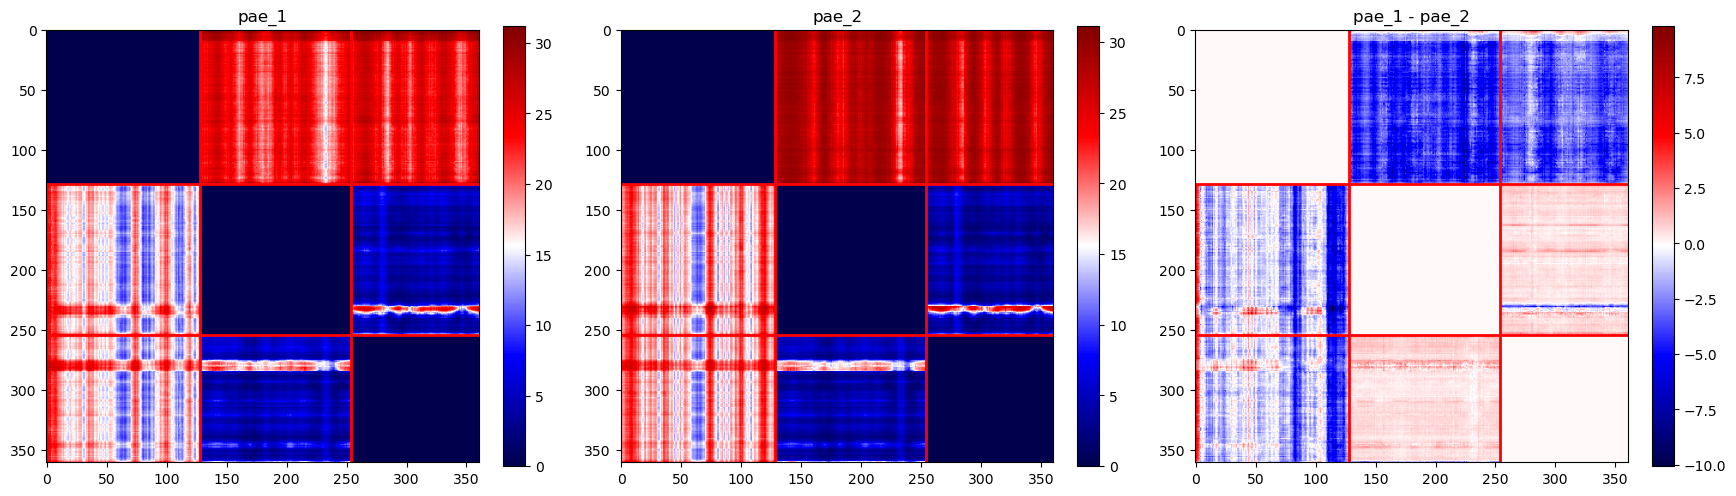

In [ ]:

plot_matrix(
    mat1=pae1*interface_mask,
    mat2=pae2*interface_mask,
    name1='pae_1',
    name2='pae_2',
    limits1=get_chain_limits(asym_id_1),
    limits2=get_chain_limits(asym_id_2),
    #title="Predicted Aligned Error"
)

In [ ]:
asym_id_1[:, None] != asym_id_1[None, :]

array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

In [ ]:
print(f"{id} model={model} prediction{prediction}")
print(f"Norm aligned_confidence_probs: {np.linalg.norm(aligned_confidence_probs_1 - aligned_confidence_probs_2)/num_res} ")
print(f"Norm interface aligned_confidence_probs: {np.linalg.norm(aligned_confidence_probs_1*interface_mask[:,:,None] - aligned_confidence_probs_2*interface_mask[:,:,None])/num_res} ")
print(f"Norm ptm_terms_diff/num_res: {np.linalg.norm(predicted_tm_terms_1-predicted_tm_terms_2)/num_res}")
print(f"Norm pae_diff/num_res: {np.linalg.norm(pae1-pae2)/num_res}")
print(f"Norm interface pae_diff/num_res: {np.linalg.norm(pae1*interface_mask-pae2*interface_mask)/num_res}")
print(f"mean pae_diff: {(pae1*interface_mask-pae2*interface_mask).mean()}")
print(f"ptm_diff: {ptm_diff}")
print(f"ptm_diff_acb: {ptm_diff_acb}")
print(f"iptm_diff: {iptm_diff}")
print(f"iptm_diff_acb: {iptm_diff_acb}")

7x8t model=model_5_multimer_v3 prediction9
Norm aligned_confidence_probs: 0.11193961780157116 
Norm interface aligned_confidence_probs: 0.10368945261778263 
Norm ptm_terms_diff/num_res: 0.062025395885175416
Norm pae_diff/num_res: 2.558360937229484
Norm interface pae_diff/num_res: 2.2573277692715545
mean pae_diff: -1.0394784212112427
ptm_diff: 0.012181752796601275
ptm_diff_acb: 0.259804871368269
iptm_diff: 0.01597446453570639
iptm_diff_acb: 0.2055598713736164


In [ ]:
ptm1 = confidence_tools.calculate_predicted_tm_score(
            aligned_confidence_probs_1)
ptm2 = confidence_tools.calculate_predicted_tm_score(
            aligned_confidence_probs_2)
tptm1 = confidence_tools.calculate_predicted_tm_score(
            np.transpose(aligned_confidence_probs_1,(1,0,2)))
tptm2 = confidence_tools.calculate_predicted_tm_score(
            np.transpose(aligned_confidence_probs_2,(1,0,2)))

iptm1 = confidence_tools.calculate_predicted_tm_score(
            aligned_confidence_probs=aligned_confidence_probs_1, asym_id=asym_id_1,interface=True,)
iptm2 = confidence_tools.calculate_predicted_tm_score(
            aligned_confidence_probs=aligned_confidence_probs_2, asym_id=asym_id_2,interface=True,)
tiptm1 = confidence_tools.calculate_predicted_tm_score(
            aligned_confidence_probs=np.transpose(aligned_confidence_probs_1,(1,0,2)),asym_id=asym_id_1,interface=True,)
tiptm2 = confidence_tools.calculate_predicted_tm_score(
            aligned_confidence_probs=np.transpose(aligned_confidence_probs_2,(1,0,2)),asym_id=asym_id_2,interface=True,)

In [ ]:
print(f"{ptm1} {ptm2} {tptm1} {tptm2}")
print(f"{iptm1} {iptm2} {tiptm1} {tiptm2}")

0.6874789851694412 0.6752972323728399 0.6031670992048637 0.5857400390087214
0.5678999560440202 0.5519254915083138 0.4937944399156446 0.46889414331409174


unrelaxed_model_2_multimer_baseline_86 bad DockQ, bad ranking
unrelaxed_model_5_multimer_baseline_56 bad DockQ, good ranking
unrelaxed_model_4_multimer_baseline_3 good DockQ, good ranking
unrelaxed_model_4_multimer_baseline_79 good DockQ, good ranking (same position as 3)

6e63_H_L_P_ab ('unrelaxed_model_5_multimer_baseline_56', 'unrelaxed_model_4_multimer_baseline_3')
Norm aligned_confidence_probs: 0.09952395895253056 
Norm interface aligned_confidence_probs: 0.07386507676995319 
Norm ptm_terms_diff/num_res: 0.10121440534807342
Norm pae_diff/num_res: 3.007536846658458
Norm interface pae_diff/num_res: 2.2519841401473335
ptm_diff: 0.00776759484691103
ptm_diff_acb: 0.6266805935114343
iptm_diff: 0.00776759484691103
iptm_diff_acb: 0.6266805935114343

6e63_H_L_P_ab ('unrelaxed_model_2_multimer_baseline_86', 'unrelaxed_model_5_multimer_baseline_56')
Norm aligned_confidence_probs: 0.24769022153771442 
Norm interface aligned_confidence_probs: 0.23589938619862433 
Norm ptm_terms_diff/num_res: 0.23991162954487014
Norm pae_diff/num_res: 8.127562813136889
Norm interface pae_diff/num_res: 7.810706097146739
ptm_diff: -0.14466622292774478
ptm_diff_acb: 0.508788795260116
iptm_diff: -0.14466622292774478
iptm_diff_acb: 0.508788795260116

6e63_H_L_P_ab ('unrelaxed_model_5_multimer_baseline_79', 'unrelaxed_model_4_multimer_baseline_3')
Norm aligned_confidence_probs: 0.05344495047693667 
Norm interface aligned_confidence_probs: 0.0401785451432933 
Norm ptm_terms_diff/num_res: 0.042115010331248426
Norm pae_diff/num_res: 1.2970380368440046
Norm interface pae_diff/num_res: 1.0937026479969854
ptm_diff: -0.0015190656278757375
ptm_diff_acb: 0.4737392396760566
iptm_diff: -0.0015190656278757375
iptm_diff_acb: 0.4737392396760566

# TODO

difference between coordinates (how similar are the models)
L2 norm
Ground truth

(use loss function: bin exact distances and compute error)


clustering: use foldseek (new version multi sequence)

cluster on l2 norm of pae difference

if two models are very similar, but one has a good ranking score and one a bad ranking score, can we say that both are bad? I.e. is the ranking score better at judging that a model is bad or good or neither?
(Are there cases where a good model gets a bad ranking score?)